In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.plotly as py
py.sign_in('lemoga', 'tljxTgI7TUZjMSUOtbsP')
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode() #run at the start of every notebook

In [2]:
IN_DIR = "/ebio/abt3_projects/TwinsUK_viromes_Shao_Pei/tmp2/"
OUT_DIR = "/ebio/abt3_projects/TwinsUK_viromes_Shao_Pei/tmp2/09_abundanceSpecificViruses/"

### Import recruitment matrix

In [3]:
#Recruitment matrix load

#abundanceMatrix = pd.read_csv(IN_DIR+"08_DiversityIndexes/matrix.counts.readsXContigs.remotion.ForAlpha.1300.transposed.csv",
#                              header=0,index_col=0,sep='\t')
abundanceMatrix = pd.read_csv(IN_DIR+"05_abundanceDistributions/matrix.counts.readsXContigs.remotion.ForAlpha.csv",
                              header=0,index_col=0,sep='\t')
abundanceMatrix = abundanceMatrix.T

#Build a dict for tax contig names and old names
#newNames is a list of how contigs are named
newNames = []
for index in abundanceMatrix.index.values:
    index = index.split('_')
    num = index[0]
    sample = index[1]
    newNames.append(sample+"_contig"+num)
contigsNamesDict = dict(zip(abundanceMatrix.index.values,newNames))

abundanceMatrix.rename(index=contigsNamesDict,inplace=True)
abundanceMatrix.head()

Ab1  Ab2   B1   B2  Da1  Da2        E1   E2        H1   H2  \
K1_contig10002  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
K2_contig10002  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
T1_contig10002  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
K1_contig10003  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
T1_contig10003  0.0  0.0  0.0  0.0  0.0  0.0  0.342076  0.0  0.758666  0.0   

               ...         T1   T2   U1   U2   W1        W2   X1   X2   Y1  \
K1_contig10002 ...   0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
K2_contig10002 ...   0.000000  0.0  0.0  0.0  0.0  0.603974  0.0  0.0  0.0   
T1_contig10002 ...   1.387957  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
K1_contig10003 ...   0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
T1_contig10003 ...   1.383282  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   

                 Y2  
K1_contig10002  0.0  
K2_contig10002  0.0  
T1_contig10002  0.0  
K1_contig10003  0.0  
T1_contig10003  0.0  

[5 rows x 42 columns]

In [4]:
#Import taxonomy annotation.
taxAnnotation = pd.read_csv(IN_DIR+"0X_contigAnnotation/contigsVsVIRALtax.votingSystem.PlusHost.PlusMicroviridae.PlusCrAssphage.WithoutRNAviruses.txt",
                            sep='\t',header=0)
taxAnnotation.fillna("Unknown",inplace=True)
taxAnnotation.set_index("CONTIG",inplace=True)
taxAnnotation.head()

HOST     HOST2  ROOT         K  \
CONTIG                                                       
Y2_contig8194   Bacteria-Archaea  Bacteria  root   Viruses   
L1_contig1082   Bacteria-Archaea  Bacteria  root   Viruses   
Ra1_contig2351  Bacteria-Archaea  Bacteria  root   Viruses   
M1_contig8976   Bacteria-Archaea  Bacteria  root   Viruses   
M2_contig923    Bacteria-Archaea  Bacteria  root   Viruses   

                                        TYPE          ORDER  \
CONTIG                                                        
Y2_contig8194    dsDNA viruses, no RNA stage   Caudovirales   
L1_contig1082    dsDNA viruses, no RNA stage   Caudovirales   
Ra1_contig2351   dsDNA viruses, no RNA stage   Caudovirales   
M1_contig8976    dsDNA viruses, no RNA stage   Caudovirales   
M2_contig923     dsDNA viruses, no RNA stage   Caudovirales   

                           FAMILY      SUBFAMILY            GENUS  \
CONTIG                                                              
Y2_contig8194    Ackermannviridae   Aglimvirinae   Limestonevirus   
L1_contig1082    Ackermannviridae   Aglimvirinae   Limestonevirus   
Ra1_contig2351   Ackermannviridae   Aglimvirinae   Limestonevirus   
M1_contig8976    Ackermannviridae     Cvivirinae      Cba120virus   
M2_contig923     Ackermannviridae     Cvivirinae      Cba120virus   

                                 SPECIES Unnamed: 11  
CONTIG                                                
Y2_contig8194                    Unknown     Unknown  
L1_contig1082    Dickeya virus Limestone     Unknown  
Ra1_contig2351                   Unknown     Unknown  
M1_contig8976                    Unknown     Unknown  
M2_contig923     Escherichia virus PhaxI     Unknown

In [5]:
abundanceMatrixPlusTaxonomy = abundanceMatrix.merge(taxAnnotation,how="inner",left_index=True,right_index=True)
abundanceMatrixPlusTaxonomy.shape

(12751, 53)

### Get the crAss contigs

In [6]:
#Those annotated from the MCP protein
fr = open(IN_DIR+"06_hmmAnnotation/crAss/proteinsWithMCPcrass.greaterThan450bp.coverage50.pIdent40.txt",'r')
vp1Proteins = fr.readlines() #MCP
fr.close()

vp1ProteinsDF = pd.DataFrame(columns=["Protein","Contig"])
p = [] #proteinNames
c = [] #contigNames
for protein in vp1Proteins:
    x = protein.strip('\n')[1:]
    p.append(x)
    c.append(x.split('>')[1])
vp1ProteinsDF["Protein"] = p
vp1ProteinsDF["Contig"] = c

vp1ProteinsDF.head()

Protein         Contig
0  gene_137884|GeneMark.hmm|450_aa|+|3977|5329_>L...  L2_contig2337
1  gene_152075|GeneMark.hmm|494_aa|+|748|2232_>M2...    M2_contig91
2  gene_152378|GeneMark.hmm|494_aa|+|3870|5354_>M...   M2_contig165
3  gene_181851|GeneMark.hmm|490_aa|+|6790|8262_>O...  O2_contig4769
4  gene_83204|GeneMark.hmm|503_aa|+|1014|2525_>H1...   H1_contig311

In [7]:
crAssContigs = abundanceMatrixPlusTaxonomy[abundanceMatrixPlusTaxonomy["FAMILY"]==" crAssphage"]
crAssContigsRA = crAssContigs.groupby("GENUS").sum()/abundanceMatrix.sum(axis=0) #relative abuandance of crAssphage by GENUS
crAssContigsRA.to_csv(OUT_DIR+"relativeAbundanceCrassphage.csv",header=True,index=True,sep='\t')

In [8]:
traces = []
for index in crAssContigsRA.index.values:
    trace = go.Bar(y=crAssContigsRA.loc[index]*100,
                   x=crAssContigsRA.columns.values,
                   name=index)
    traces.append(trace)
layout = go.Layout(yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)

In [9]:
#calculate cumulative abundace to make the plot.
crAssContigsRA.loc[" IAS virus group"] = crAssContigsRA.loc[" IAS virus group"] + crAssContigsRA.loc[" Chlamydia virus group"] 
crAssContigsRA.loc[" uncultured crAssphage"] = crAssContigsRA.loc[" uncultured crAssphage"] + crAssContigsRA.loc[" IAS virus group"] 

traces = []
for index in crAssContigsRA.index.values[::-1]:
    trace = go.Scatter(y=crAssContigsRA.loc[index]*100,
                       x=crAssContigsRA.columns.values,
                       fill="tozeroy",name=index)
    traces.append(trace)
layout = go.Layout(title="Cumulative relative abundance of crAssphage family",
                   yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)    

### Get the Microviridae contigs

In [10]:
microviridaeContigs = abundanceMatrixPlusTaxonomy[abundanceMatrixPlusTaxonomy["FAMILY"]==" Microviridae"]
microviridaeContigsRA = microviridaeContigs.groupby("SUBFAMILY").sum()/abundanceMatrix.sum(axis=0) #relative abuandance of crAssphage by GENUS
microviridaeContigsRA.to_csv(OUT_DIR+"relativeAbundanceMicroviridae.csv",header=True,index=True,sep='\t')

In [11]:
traces = []
for index in microviridaeContigsRA.index.values:
    trace = go.Bar(y=microviridaeContigsRA.loc[index]*100,
                   x=microviridaeContigsRA.columns.values,
                   name=index)
    traces.append(trace)
layout = go.Layout(yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)

In [12]:
#calculate cumulative abundace to make the plot.
for i in range(1,len(microviridaeContigsRA.index.values)):
    microviridaeContigsRA.iloc[i] = microviridaeContigsRA.iloc[i] + microviridaeContigsRA.iloc[i-1]

traces = []
for index in microviridaeContigsRA.index.values[::-1]:
    trace = go.Scatter(y=microviridaeContigsRA.loc[index]*100,
                       x=microviridaeContigsRA.columns.values,
                       fill="tozeroy",name=index)
    traces.append(trace)
layout = go.Layout(title="Cumulative relative abundance of Microviridae family",
                   yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)    

### Get the Megavirales/NCLDV contigs

In [19]:
taxAnnotation["ORDER"].unique()

array([' Caudovirales', 'Unknown', ' Herpesvirales', ' Ligamenvirales',
       ' Megavirales', ' Ortervirales'], dtype=object)

In [29]:
taxAnnotation[taxAnnotation["ORDER"]==" Megavirales"]["FAMILY"].unique()

array([' Ascoviridae', ' Iridoviridae', ' Marseilleviridae',
       ' Mimiviridae', ' Phycodnaviridae', ' Pithoviridae', ' Poxviridae',
       'Pandoraviridae'], dtype=object)

In [30]:
taxAnnotation["FAMILY"].unique()

array([' Ackermannviridae', ' Myoviridae', ' crAssphage', ' Podoviridae',
       ' Siphoviridae', ' unclassified Caudovirales', 'Unknown',
       ' Herpesviridae', ' Lipothrixviridae', ' Ascoviridae',
       ' Iridoviridae', ' Marseilleviridae', ' Mimiviridae',
       ' Phycodnaviridae', ' Pithoviridae', ' Poxviridae',
       ' Caulimoviridae', ' Adenoviridae', ' Anelloviridae',
       ' Baculoviridae', ' Bicaudaviridae', ' Bidnaviridae',
       ' Circoviridae', ' Genomoviridae', ' Inoviridae', ' Lavidaviridae',
       ' Microviridae', ' Nimaviridae', ' Nudiviridae',
       ' Papillomaviridae', ' Plasmaviridae', ' Polydnaviridae',
       ' Polyomaviridae', ' Rudiviridae', ' Sphaerolipoviridae',
       ' Turriviridae', 'Pandoraviridae'], dtype=object)

In [31]:
ncldvContigs = abundanceMatrixPlusTaxonomy[abundanceMatrixPlusTaxonomy["ORDER"]==" Megavirales"]
ncldvContigsRA = ncldvContigs.groupby("FAMILY").sum()/abundanceMatrix.sum(axis=0) #relative abuandance of crAssphage by GENUS
#microviridaeContigsRA.to_csv(OUT_DIR+"relativeAbundanceMicroviridae.csv",header=True,index=True,sep='\t')

In [32]:
traces = []
for index in ncldvContigsRA.index.values:
    trace = go.Bar(y=ncldvContigsRA.loc[index]*100,
                   x=ncldvContigsRA.columns.values,
                   name=index)
    traces.append(trace)
layout = go.Layout(yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)

In [33]:
#calculate cumulative abundace to make the plot.
for i in range(1,len(ncldvContigsRA.index.values)):
    ncldvContigsRA.iloc[i] = ncldvContigsRA.iloc[i] + ncldvContigsRA.iloc[i-1]

traces = []
for index in ncldvContigsRA.index.values[::-1]:
    trace = go.Scatter(y=ncldvContigsRA.loc[index]*100,
                       x=ncldvContigsRA.columns.values,
                       fill="tozeroy",name=index)
    traces.append(trace)
layout = go.Layout(title="Cumulative relative abundance of Microviridae family",
                   yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=traces,layout=layout)
plotly.offline.iplot(fig)    

### Most abundant contigs (among all samples)

In [154]:
#first 50 popular contigs per sample
mostAbundant = []
firstColumn = True
for sample in abundanceMatrix.columns.values:
    if firstColumn:
        mostAbundant = list(abundanceMatrix[sample].sort_values(ascending=False).index[:50])
        firstColumn = False
    else:
        mostAbundant = mostAbundant + list(abundanceMatrix[sample].sort_values(ascending=False).index[:50])
mostAbundant = list(set(mostAbundant))
print len(mostAbundant)

1820


In [214]:
#50 most popular in sum of abundance among samples
abundanceMatrixSortSumAbundance = abundanceMatrix.loc[list(abundanceMatrix.sum(axis=1).sort_values(ascending=False).index)]
abundanceMatrixSortSumAbundance = abundanceMatrixSortSumAbundance.iloc[:50]

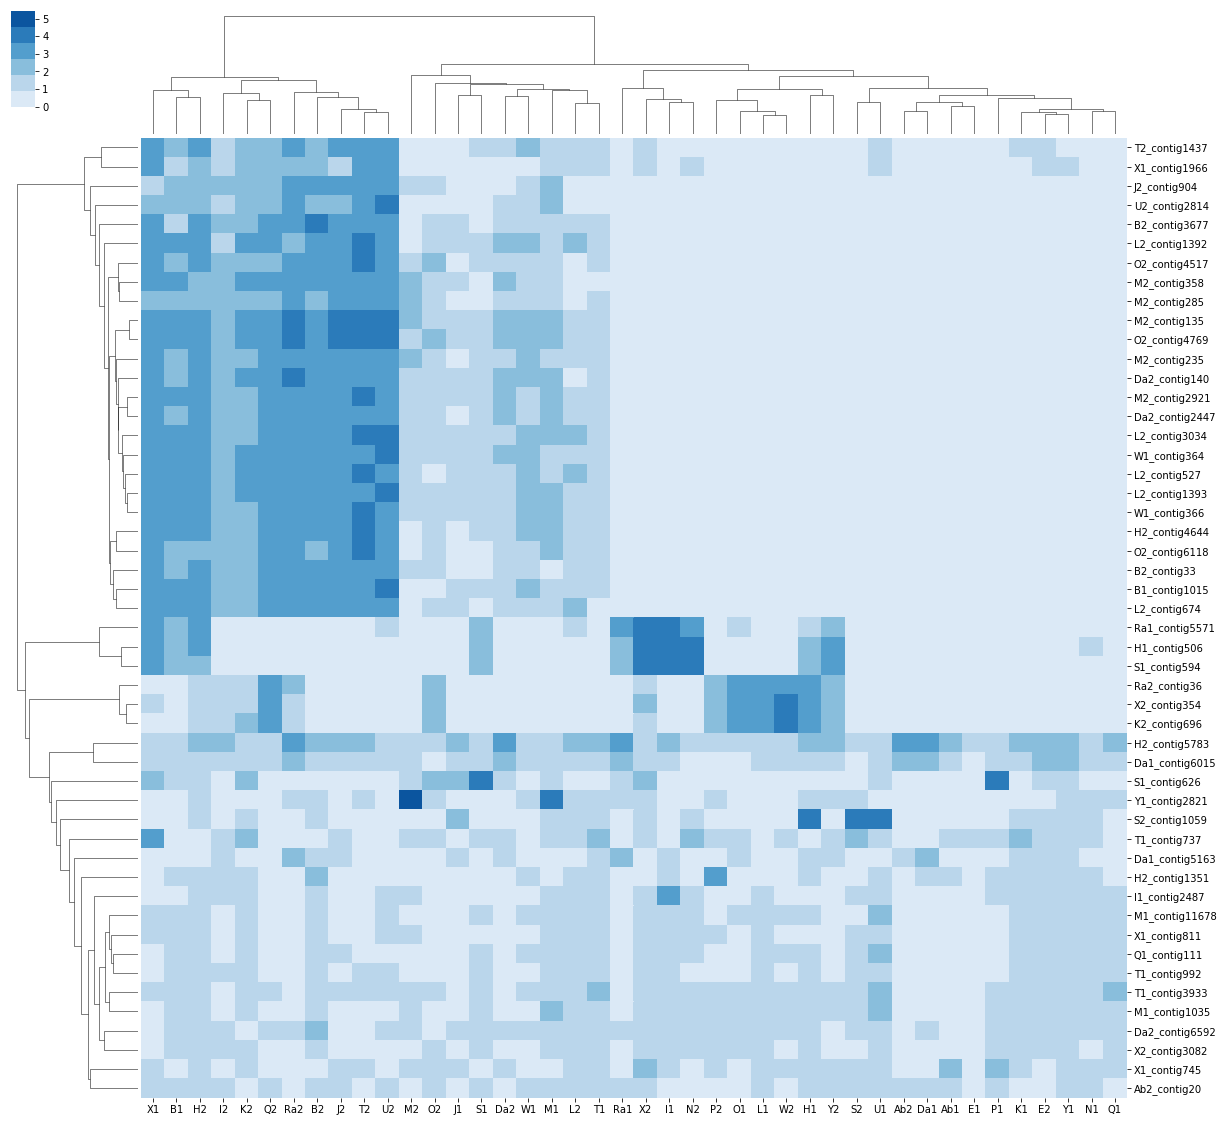

In [197]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(abundanceMatrixSortSumAbundance,cmap=seq_col_brew,row_cluster=True,col_cluster=True,
                    annot=False,figsize=[20,20])
plt.show()

In [198]:
#How many are annotated as crAssphage?
print len(set(abundanceMatrixSortSumAbundance.iloc[:50].index)&set(crAssContigs.index))
for x in set(abundanceMatrixSortSumAbundance.iloc[:50].index)&set(crAssContigs.index):
    print x

28
H2_contig4644
L2_contig1393
L2_contig1392
L2_contig674
Da2_contig2447
W1_contig364
W1_contig366
M2_contig235
O2_contig4517
M2_contig2921
B2_contig3677
Da2_contig140
L2_contig527
T2_contig1437
B1_contig1015
S1_contig594
O2_contig6118
M2_contig285
M2_contig135
K2_contig696
M2_contig358
X1_contig1966
L2_contig3034
U2_contig2814
B2_contig33
O2_contig4769
Ra2_contig36
J2_contig904


In [ ]:
19
O2_contig4721 5306
L2_contig2337 6024
E2_contig721 7951
H1_contig311 3049
K2_contig696 32696
N2_contig818 15078
O2_contig4769 15744
M2_contig165 8620
Y2_contig3058 15690
P1_contig8255 3744
P2_contig635 5130
Ab2_contig1 32736
Y2_contig4640 1640
M1_contig2523 9401
Da2_contig363 22263
X2_contig3450 3204
S1_contig433 7931
B1_contig778 22341
M2_contig91 16916

In [215]:
#How many were annotated as crAssphage using the MCP
print len(set(abundanceMatrixSortSumAbundance.iloc[:].index)&set(vp1ProteinsDF["Contig"]))
for x in set(abundanceMatrixSortSumAbundance.iloc[:].index)&set(vp1ProteinsDF["Contig"]):
    print x

2
K2_contig696
O2_contig4769


### Plot Heatmap

In [158]:
abundanceMatrixSorted = abundanceMatrix.loc[list(crAssContigs)+list(others)]

NameError: name 'others' is not defined

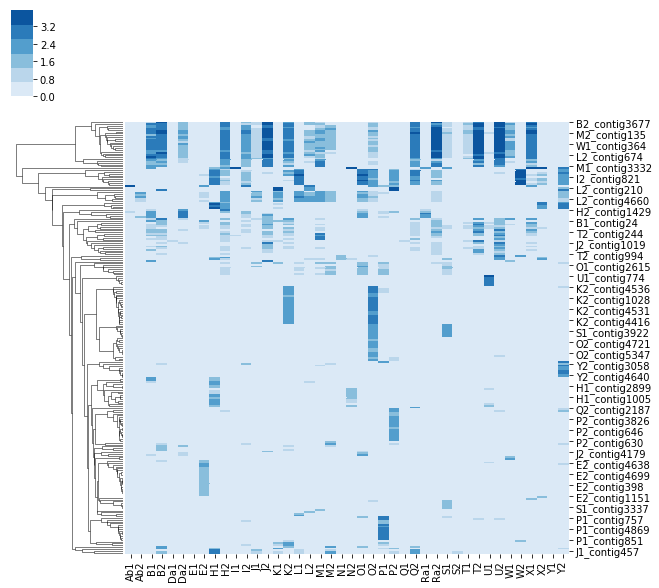

In [67]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(crAssContigs,cmap=seq_col_brew,row_cluster=True,col_cluster=False,
                    annot=False)
plt.show()

In [10]:
#It is no suitable to plot all the contigs in a heatmap

### Heatmap with top 50 contigs (based on sum of abundance)

In [68]:
abundanceMatrixSortSumAbundance = abundanceMatrix.loc[list(abundanceMatrix.sum(axis=1).sort_values(ascending=False).index)]

In [69]:
abundanceMatrix.shape

(14584, 42)

In [70]:
len(set(abundanceMatrixSortSumAbundance.index[:50])&set(crAssContigs.index))

28

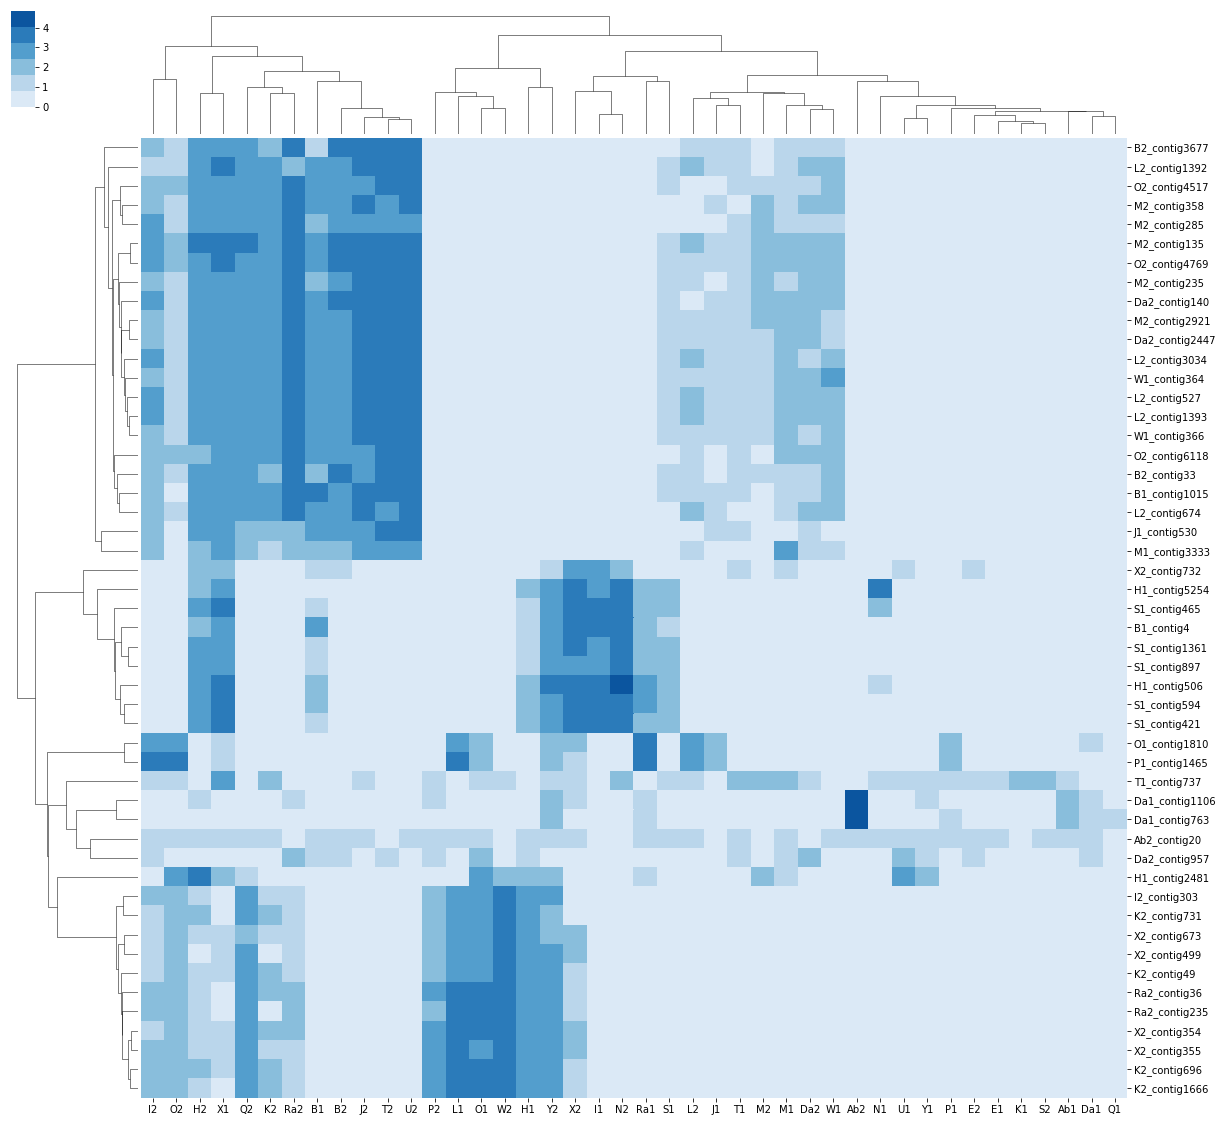

In [71]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(abundanceMatrixSortSumAbundance.iloc[:50],cmap=seq_col_brew,row_cluster=True,col_cluster=True,
                    annot=False,figsize=[20,20])
plt.show()

In [73]:
%%writefile top50Contigs.txt
G1_contig933
L2_contig1392
F2_contig6992
L2_contig674
G2_contig2223
O2_contig6118
H2_contig4644
B1_contig1015
M2_contig135
O2_contig4769
O2_contig4517
G2_contig1551
Da2_contig140
M2_contig358
L2_contig3034
M2_contig235
M2_contig2921
Da2_contig2447
W1_contig364
L2_contig527
L2_contig1393
W1_contig366
L2_contig5176
M2_contig285
J1_contig530
H2_contig4930
J2_contig904
X1_contig1966
O2_contig5237
M1_contig3333
S1_contig626
Y1_contig2821
H2_contig5783
Da1_contig6015
T1_contig737
F1_contig6125
F2_contig541
Da2_contig6592
T2_contig1437
U2_contig273
T1_contig3933
U1_contig1402
X2_contig85
H1_contig506
P2_contig1336
K2_contig731
K2_contig696
G1_contig6556
G1_contig710
X2_contig355

Writing top50Contigs.txt


In [102]:
fr = open("top50Contigs.txt")
abundantContigs = []
for line in fr:
    abundantContigs.append(line.strip('\n'))
fr.close()
print abundantContigs

['G1_contig933', 'L2_contig1392', 'F2_contig6992', 'L2_contig674', 'G2_contig2223', 'O2_contig6118', 'H2_contig4644', 'B1_contig1015', 'M2_contig135', 'O2_contig4769', 'O2_contig4517', 'G2_contig1551', 'Da2_contig140', 'M2_contig358', 'L2_contig3034', 'M2_contig235', 'M2_contig2921', 'Da2_contig2447', 'W1_contig364', 'L2_contig527', 'L2_contig1393', 'W1_contig366', 'L2_contig5176', 'M2_contig285', 'J1_contig530', 'H2_contig4930', 'J2_contig904', 'X1_contig1966', 'O2_contig5237', 'M1_contig3333', 'S1_contig626', 'Y1_contig2821', 'H2_contig5783', 'Da1_contig6015', 'T1_contig737', 'F1_contig6125', 'F2_contig541', 'Da2_contig6592', 'T2_contig1437', 'U2_contig273', 'T1_contig3933', 'U1_contig1402', 'X2_contig85', 'H1_contig506', 'P2_contig1336', 'K2_contig731', 'K2_contig696', 'G1_contig6556', 'G1_contig710', 'X2_contig355']


In [76]:
#Read all contigs derep file
from Bio import SeqIO 
fw = open('top50Contigs.fasta',"w")
for contig in SeqIO.parse("../../1_Derep/allContigs.DeRep.fna","fasta"):
    #set names of contigs in order to match the name of annotation contigs.
    index = contig.id
    index = index.split('_')
    num = index[0]
    sample = index[1]
    newName = sample+"_contig"+num
    if newName in list(abundantContigs):
        print >> fw, ">"+newName
        print >> fw, contig.seq
fw.close()

In [77]:
%%writefile blastTop50Contigs.sh
#!/bin/bash
#$ -N blastMimiNt
#$ -pe parallel 6
#$ -l h_vmem=4G
#$ -l h_rt=72:00:00
#$ -cwd
#$ -m ea
#$ -M jmoreno@tuebingen.mpg.de

blastn -db /ebio/abt3_projects/databases/NCBI_blastdb/nt -query top50Contigs.fasta -outfmt "6 qseqid pident saccver stitle staxids qlen slen qstart qend sstart send length bitscore gaps evalue" -out top50Contigs.outBlast.csv -num_threads 6

Writing blastTop50Contigs.sh


In [78]:
%%bash
qsub blastTop50Contigs.sh

Your job 1481162 ("blastMimiNt") has been submitted


### Filter contigs

In [85]:
topJoinMCP = list(set(abundanceMatrixSortSumAbundance.iloc[:50].index.values) | set(crAssContigsSorted))

In [87]:
topJoinMCPdf = abundanceMatrix.loc[topJoinMCP]

(70, 48)

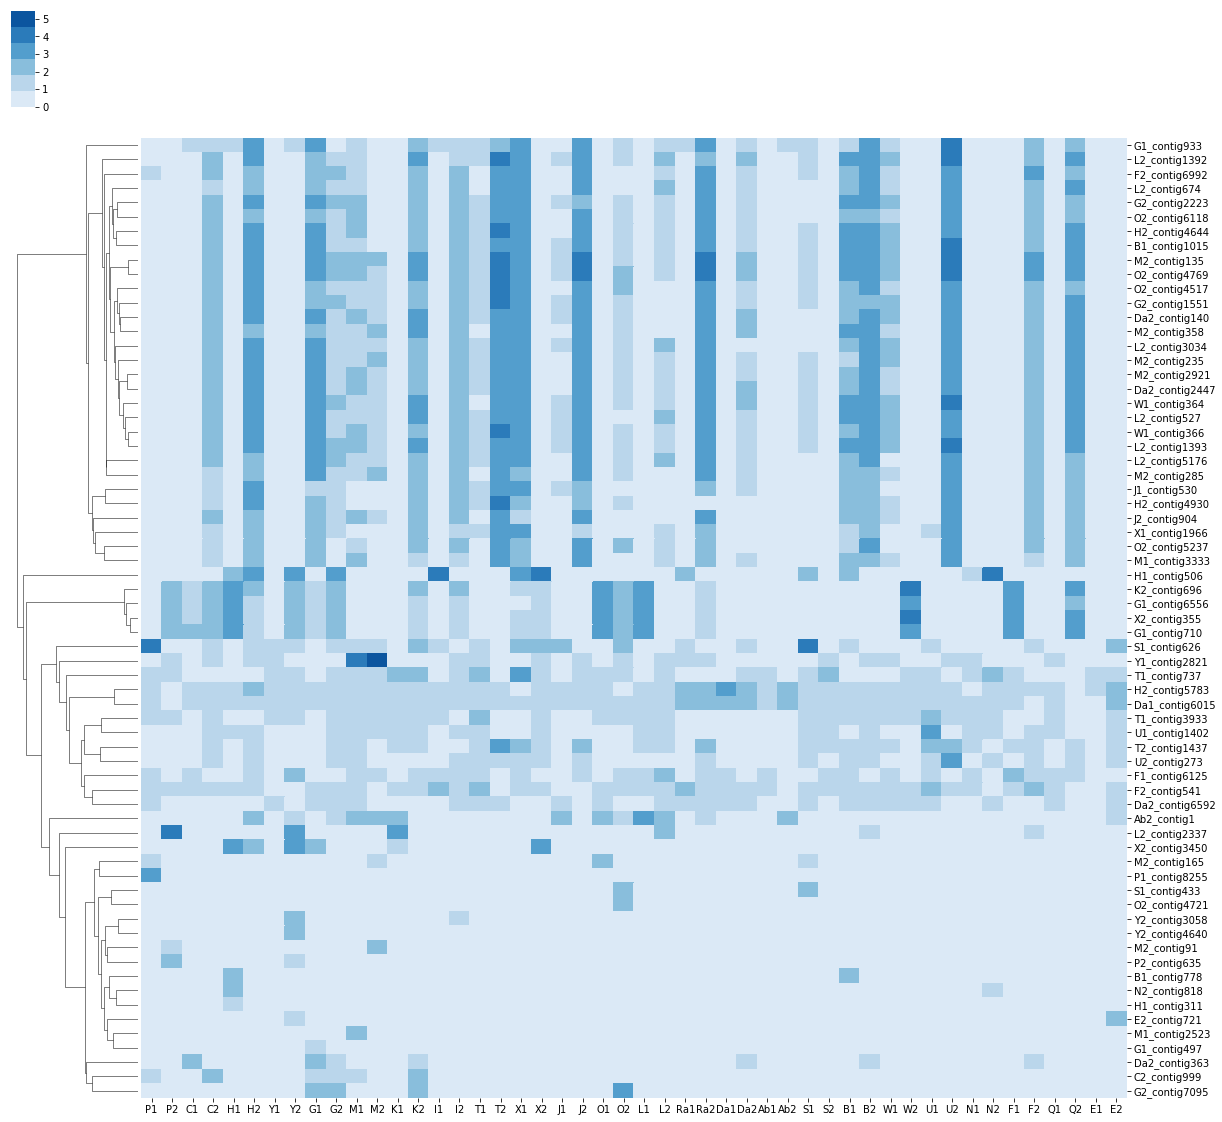

In [97]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(abundanceMatrixSorted,cmap=seq_col_brew,row_cluster=True,col_cluster=False,
                    annot=False,figsize=[20,20])
plt.show()

In [98]:
ax.savefig("Top50ContigsPlusCrAssContigs.pdf")

### Old Filter contigs

In [48]:
crAssContigsSorted = list(abundanceMatrix.sum(axis=1).loc[list(crAssContigs)].sort_values(ascending=False).index)
othersSorted = list(abundanceMatrix.sum(axis=1).loc[list(others)][abundanceMatrix.sum(axis=1).loc[list(others)] >= 40].sort_values(ascending=False).index)

In [49]:
print len(othersSorted)

41


In [50]:
abundanceMatrixSorted = abundanceMatrix.loc[crAssContigsSorted + othersSorted]

In [51]:
mapping = pd.read_csv("../../48MZ_Virome_Sample_Information.csv",sep='\t',header=0)
mapping.sort_values(by=["Con_Dis","Ebi_ID"],inplace=True)
mapping.head()
abundanceMatrixSorted = abundanceMatrixSorted[mapping["Sample_ID"]]

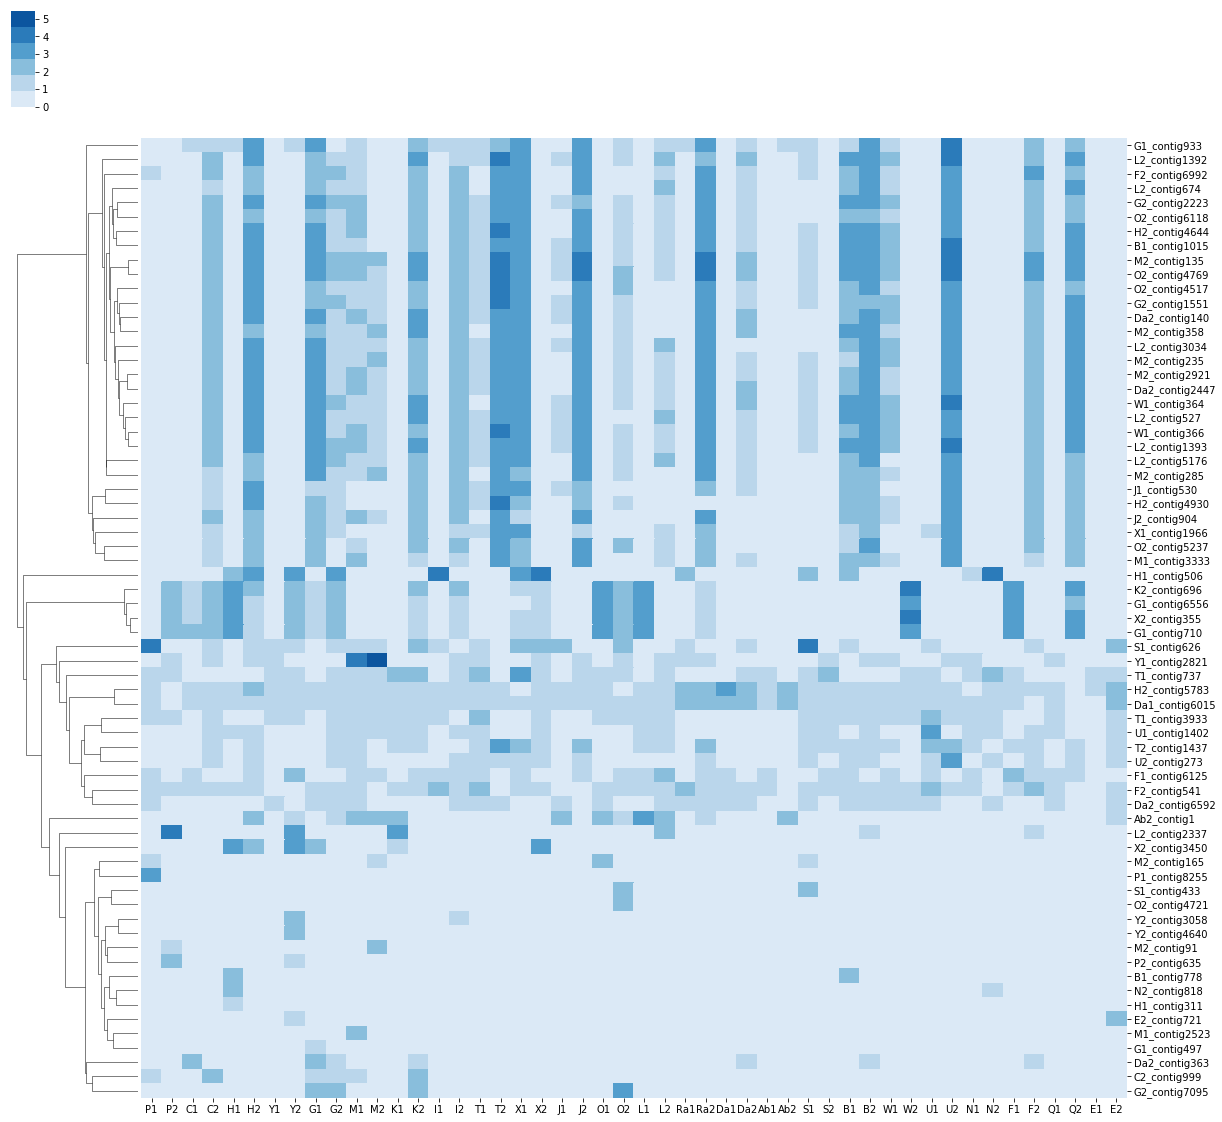

In [52]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(abundanceMatrixSorted,cmap=seq_col_brew,row_cluster=True,col_cluster=False,
                    annot=False,figsize=[20,20])
plt.show()

In [41]:
ax.savefig("mostAbundantContigsPlusCrAssContigs.pdf")

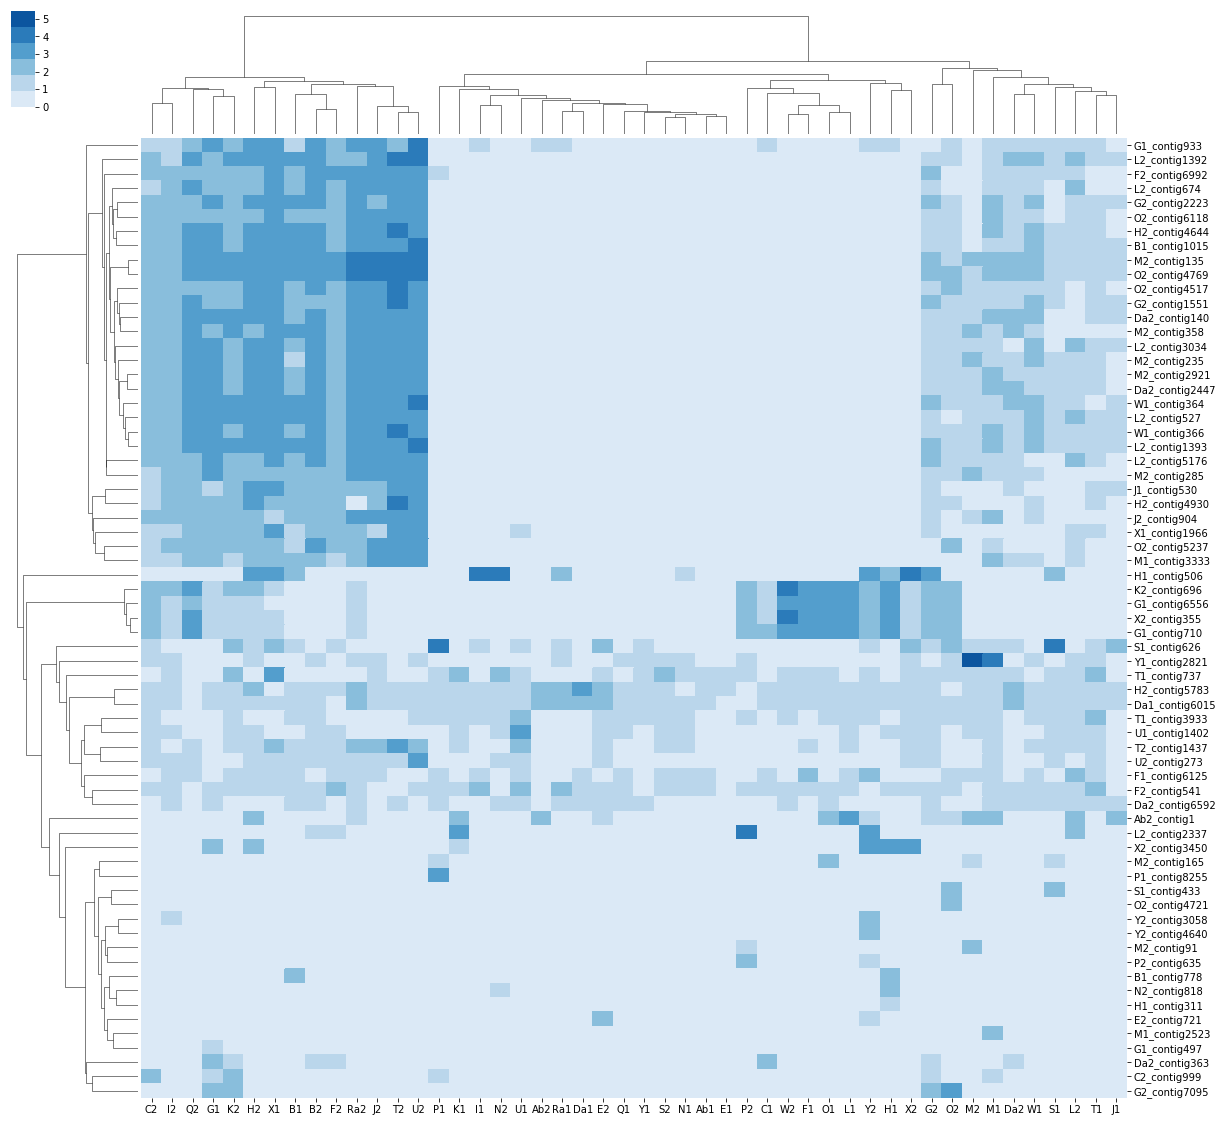

In [14]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(abundanceMatrixSorted,cmap=seq_col_brew,row_cluster=True,col_cluster=True,
                    annot=False,figsize=[20,20])
plt.show()

In [21]:
test = abundanceMatrixSorted.drop(["H1_contig506"],axis=0)

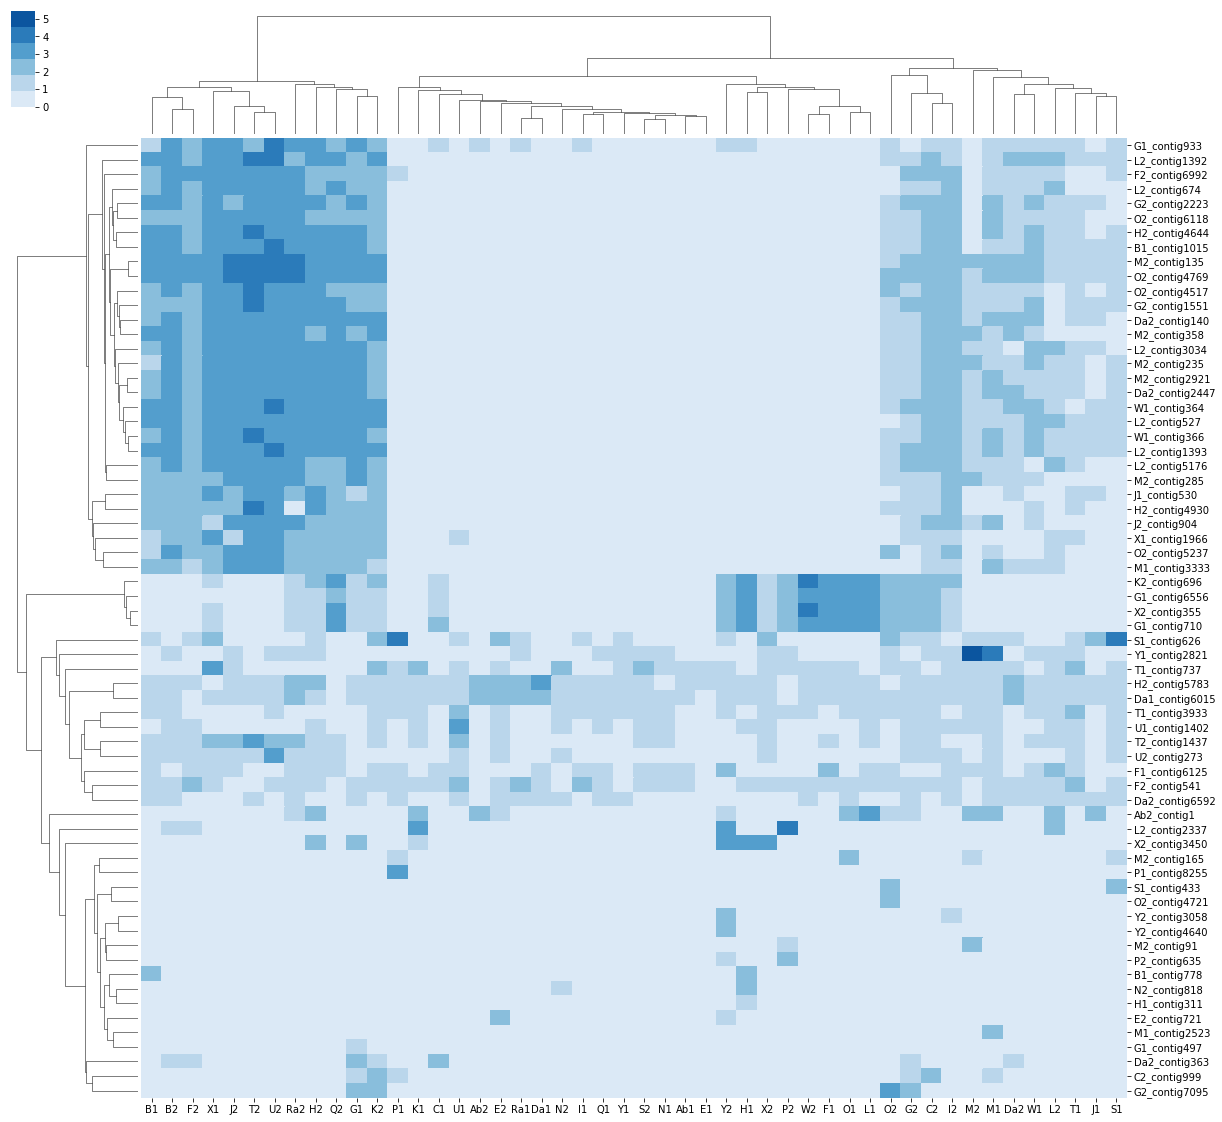

In [22]:
seq_col_brew = sns.color_palette("Blues",6)
ax = sns.clustermap(test,cmap=seq_col_brew,row_cluster=True,col_cluster=True,
                    annot=False,figsize=[20,20])
plt.show()

In [40]:
for x in ax.data2d.index:
    print x

G1_contig933
L2_contig1392
F2_contig6992
L2_contig674
G2_contig2223
O2_contig6118
H2_contig4644
B1_contig1015
M2_contig135
O2_contig4769
O2_contig4517
G2_contig1551
Da2_contig140
M2_contig358
L2_contig3034
M2_contig235
M2_contig2921
Da2_contig2447
W1_contig364
L2_contig527
W1_contig366
L2_contig1393
L2_contig5176
M2_contig285
J1_contig530
H2_contig4930
J2_contig904
X1_contig1966
O2_contig5237
M1_contig3333
H1_contig506
K2_contig696
G1_contig6556
X2_contig355
G1_contig710
S1_contig626
Y1_contig2821
T1_contig737
H2_contig5783
Da1_contig6015
T1_contig3933
U1_contig1402
T2_contig1437
U2_contig273
F1_contig6125
F2_contig541
Da2_contig6592
Ab2_contig1
L2_contig2337
X2_contig3450
M2_contig165
P1_contig8255
S1_contig433
O2_contig4721
Y2_contig3058
Y2_contig4640
M2_contig91
P2_contig635
B1_contig778
N2_contig818
H1_contig311
E2_contig721
M1_contig2523
G1_contig497
Da2_contig363
C2_contig999
G2_contig7095


### checkBlast

In [53]:
!cat abundantClade.*outBlast* > top50.outBlast.csv

In [56]:
#1. Import file
blast = pd.read_csv("top50.outBlast.csv",sep='\t',header=None)
header = ["qseqid","pident","saccver","stitle","staxids","qlen","slen","qstart","qend","sstart","send","length","bitscore","gaps","evalue"]
blast.columns = header
blast.head()

qseqid  pident     saccver  \
0  T1_contig737   99.90  AB775653.1   
1  T1_contig737  100.00  AB775653.1   
2  T1_contig737   94.10  LN853919.1   
3  T1_contig737   98.36  LN853919.1   
4  T1_contig737   98.62  AB646744.1   

                                              stitle  staxids  qlen   slen  \
0  Escherichia coli-Bacteroides shuttle vector pV...  1280924  4348  10822   
1  Escherichia coli-Bacteroides shuttle vector pV...  1280924  4348  10822   
2  Uncultured prokaryote from Rat gut metagenome ...   198431  4348   4134   
3  Uncultured prokaryote from Rat gut metagenome ...   198431  4348   4134   
4  Bacteroides fragilis plasmid pBFUK1 DNA, compl...      817  4348  12817   

   qstart  qend  sstart   send  length  bitscore  gaps  evalue  
0     352  4348   10822   6827    3997    7358.0     1     0.0  
1       1   356    7025   6670     356     658.0     0     0.0  
2       1  2400    2396      1    2405    3642.0    14     0.0  
3    2401  4348    4134   2198    1948    3410.0    11     0.0  
4    2327  4348    9812  11822    2022    3568.0    11     0.0

In [58]:
#2. Sort by query id and bitscore
blastSorted = blast.sort_values(by=["qseqid","bitscore"],ascending=[True,False])

In [68]:
#3. Save and explore in excel
blastSorted.to_csv("top50.outBlast.sorted.csv",sep='\t')

In [62]:
crAss = []
noCrAss = []
for x in blastSorted["qseqid"].unique():
    if "crAssphage" in blastSorted[blastSorted["qseqid"]==x].iloc[0]["stitle"]:
        crAss.append(x)
    else:
        noCrAss.append(x)

### Plot area plots

In [89]:
abundanceMatrix = abundanceMatrix[mapping["Sample_ID"]]

In [90]:
fr = open("crAssContigs.IASvirus.txt")
iasContigs = [x.strip('\n') for x in fr.readlines()]
fr.close()

fr = open("crAssContigs.Chlamydua.txt")
chlamydiaContigs = [x.strip('\n') for x in fr.readlines()]
fr.close()

fr = open("crAssContigs.crAssphage.txt")
crAssphageContigs = [x.strip('\n') for x in fr.readlines()]
fr.close()

In [91]:
iasAbundance = abundanceMatrix.loc[iasContigs].sum(axis=0)
chlamydiaAbundance = abundanceMatrix.loc[chlamydiaContigs].sum(axis=0)
crAssphageAbundance = abundanceMatrix.loc[crAssphageContigs].sum(axis=0)
totalAbundace = abundanceMatrix.sum(axis=0)

In [93]:
trace2 = go.Scatter(y=((chlamydiaAbundance+iasAbundance+crAssphageAbundance)/totalAbundace)*100,
                    x=abundanceMatrix.columns.values,
                    fill="tozeroy",name="crAssphage group")
trace3 = go.Scatter(y=((chlamydiaAbundance+iasAbundance)/totalAbundace)*100,
                    x=abundanceMatrix.columns.values,
                    fill="tozeroy",name="IAS virus group")
trace4 = go.Scatter(y=(chlamydiaAbundance/totalAbundace)*100,
                    x=abundanceMatrix.columns.values,
                    fill="tozeroy",name="Chlamydiaphage group")
layout = go.Layout(title="Cumulative relative abundance of crAssphage family",
                   yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=[trace2,trace3,trace4],layout=layout)
plotly.offline.iplot(fig)

In [70]:
py.image.save_as(fig,'crAssAbundance.pdf')

In [94]:
print "Mean relative abundance of the crAssphage family contigs is: %f" %(((chlamydiaAbundance+iasAbundance+crAssphageAbundance)/totalAbundace)*100).mean()
print "with an standard deviation of %f" %(((chlamydiaAbundance+iasAbundance+crAssphageAbundance)/totalAbundace)*100).std()

Mean relative abundance of the crAssphage family contigs is: 1.103120
with an standard deviation of 1.423349


In [95]:
trace1 = go.Bar(y=((chlamydiaAbundance+iasAbundance+crAssphageAbundance)/totalAbundace)*100,x=abundanceMatrix.columns.values,name="crAss Family")
trace2 = go.Bar(y=(crAssphageAbundance/totalAbundace)*100,x=abundanceMatrix.columns.values,name="crAssphage group")
trace3 = go.Bar(y=(iasAbundance/totalAbundace)*100,x=abundanceMatrix.columns.values,name="IAS virus group")
trace4 = go.Bar(y=(chlamydiaAbundance/totalAbundace)*100,x=abundanceMatrix.columns.values,name="Chlamydiaphage group")
layout = go.Layout(yaxis=dict(title="Relative Abundance (%)"))
fig = go.Figure(data=[trace2,trace3,trace4,trace1],layout=layout)
plotly.offline.iplot(fig)